In [1]:
from automorphisms import *
from ZX_dualities import *
from utils.qec import *
from utils.qiskit import *
import pickle

## [[108,8,10]] 

#### Define code

In [2]:
n = 108
k = 8
d = 10

H_X = np.load(f'../code_data/HX_n{n}k{k}d{d}.npy')
H_Z = np.load(f'../code_data/HZ_n{n}k{k}d{d}.npy')

zeros = np.zeros_like(H_X)
H_symp = np.array(np.vstack((np.hstack((H_X,zeros)),np.hstack((zeros,H_Z)))),dtype=int)

In [3]:
H_symp_rref, _, transform_rows, transform_cols = rref_mod2(H_symp)
H_symp_rref = H_symp_rref[~np.all(H_symp_rref == 0, axis=1)]
H_symp_rref_og_basis = H_symp_rref@inv_mod2(transform_cols)
assert H_symp_rref_og_basis.shape[0] == n-k
assert H_symp_rref_og_basis.shape[1] == 2*n

#### Standard form of code

In [4]:
G, LX, LZ, D = compute_standard_form(H_symp_rref_og_basis)
#print(binary_vecs_to_paulis(LX))

#### Automorphism group generators from MAGMA

In [5]:
code_auts_dict = qec_code_ZX_dualities_from_magma_with_intersection(n,k,d,H_symp_rref_og_basis).run(fileroot='./')
filename = f'./ZX_dualities_n{n}k{k}d{d}.pkl'
with open(filename, 'rb') as f:
    code_auts_dict = pickle.load(f)
print('Aut Group Order: ', code_auts_dict['order'])
print('Time: ', code_auts_dict['time'])
print('No of aut gens: ', len(code_auts_dict['auts']))

Aut Group Order:  216
Time:  0.91
No of aut gens:  5


#### Circuits of automorphism group generators

In [6]:
auts = code_auts_dict['auts']
circuits = []
symp_mats = []
for num, aut in enumerate(auts):
    #print('Aut Gen',num)
    phys_act = circ_from_ZX_duality(H_symp_rref_og_basis,aut)        
    phys_circ, _ = phys_act.circ()
    log_act = logical_circ_and_pauli_correct(H_symp_rref_og_basis,phys_circ)
    circ = log_act.run()
    circuits.append(circ)
    symp_mats.append(log_act.U_logical_act())

In [7]:
filename = f'./symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'wb') as f:
    pickle.dump(symp_mats, f)

### Logical action 1

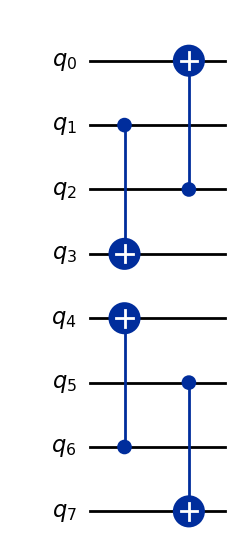

In [8]:
# logical circuit
log_act, phys_circ = circuits[0]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 2

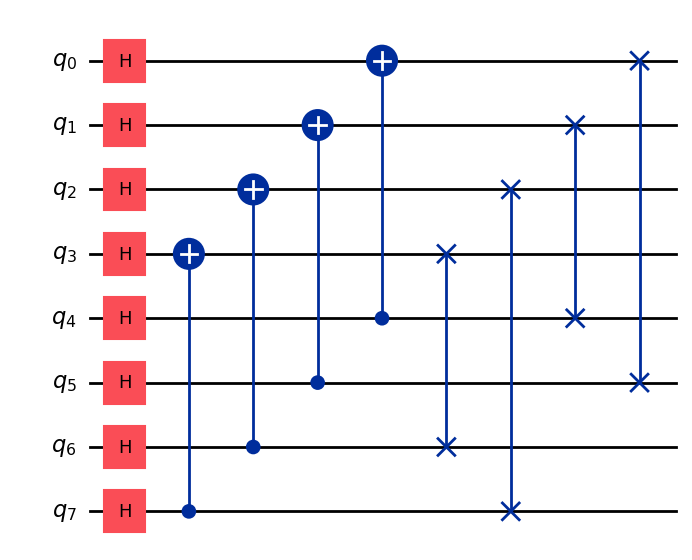

In [9]:
# logical circuit
log_act, phys_circ = circuits[1]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 3

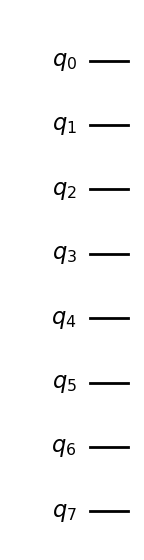

In [10]:
# logical circuit
log_act, phys_circ = circuits[2]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 4

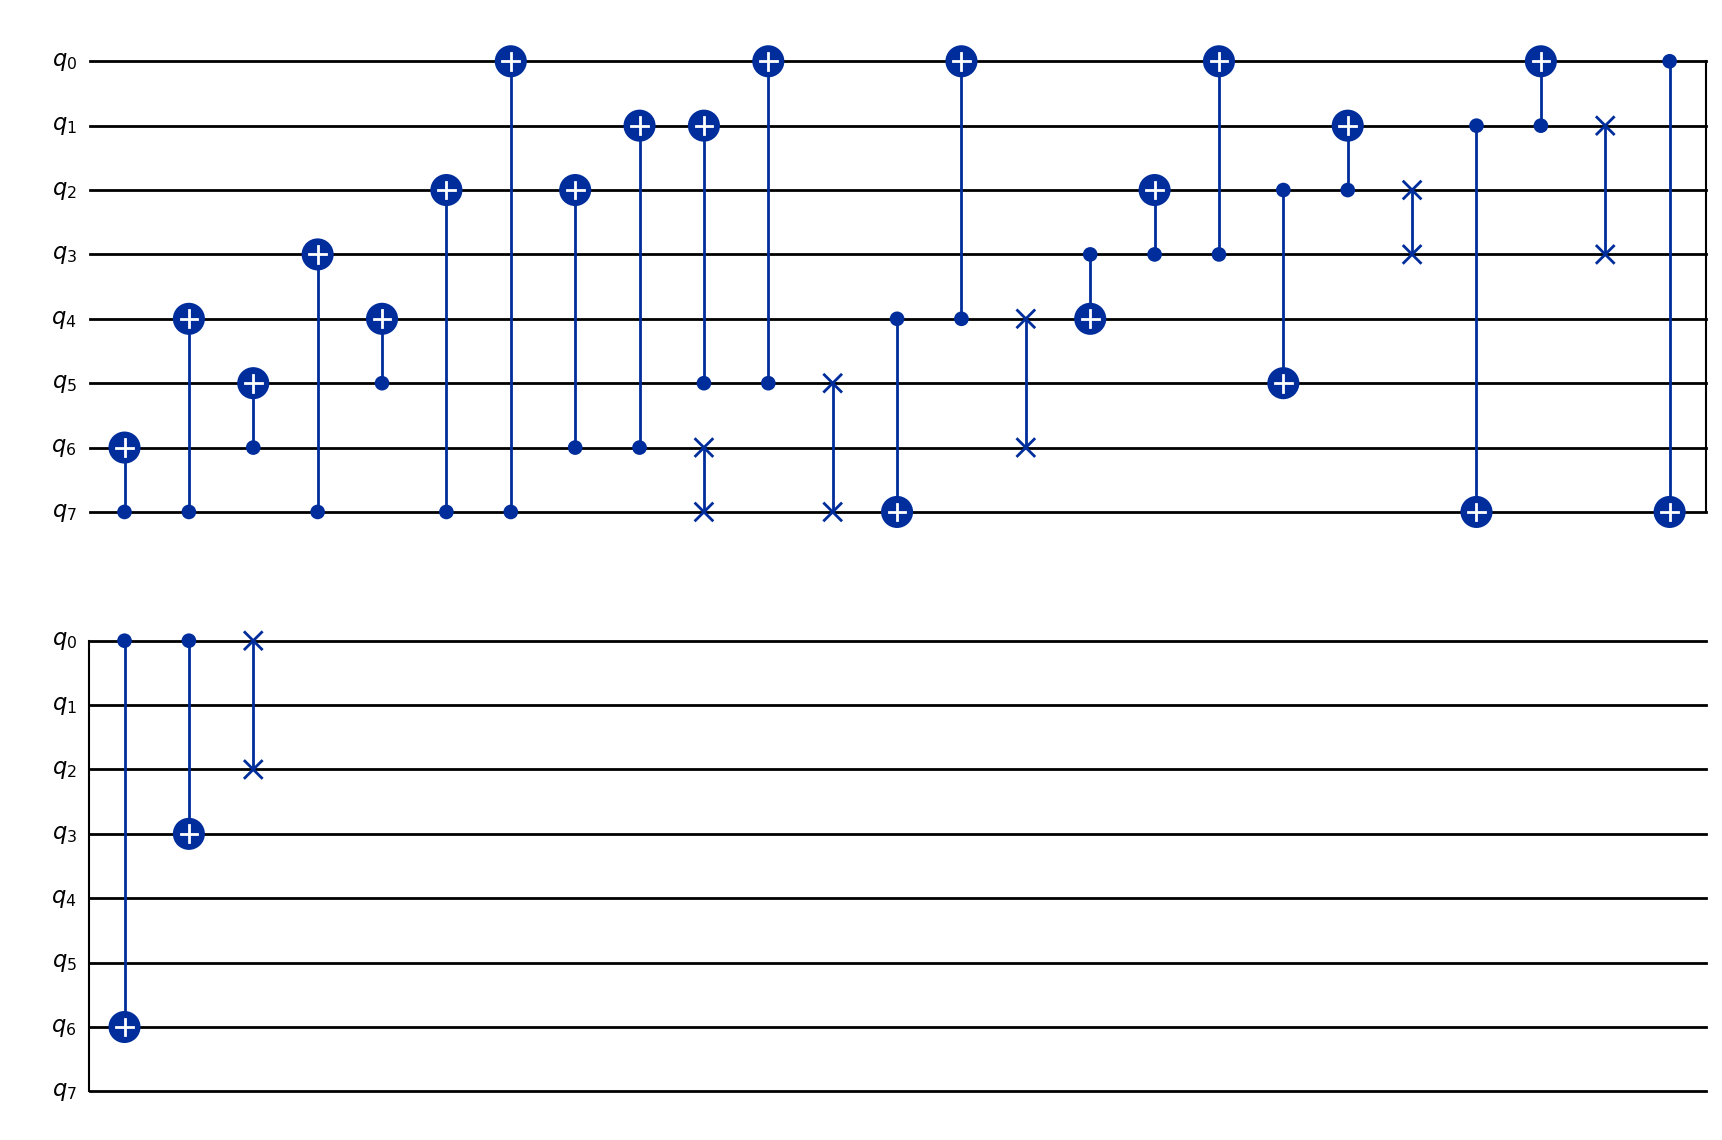

In [11]:
# logical circuit
log_act, phys_circ = circuits[3]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

### Logical action 5

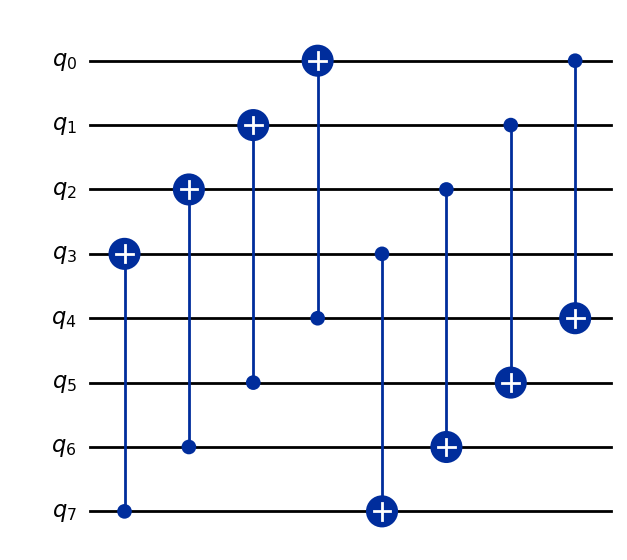

In [12]:
# logical circuit
log_act, phys_circ = circuits[4]
qc = construct_circuit(log_act, k)
qc.draw(output='mpl')

## Logical gate group structure

In [13]:
filename = f'./symp_mats_n{n}k{k}d{d}.pkl'
with open(filename, 'rb') as f:
    symp_mats = pickle.load(f)

In [14]:
from logical_subgroups import *
gate_group = clifford_subgroups(k,symp_mats)
print(gate_group.return_order())
print(gate_group.return_structure())

36
S3^2
